In [310]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

In [311]:
def load_sudoku(filename):
    with open(f"sudoku_boards/{filename}", "r") as file:
        return [[int(x) for x in (row[:-1] if row[-1]=='\n' else row)] for row in file.readlines()]

In [312]:
def show_sudoku(board):
    m = 360
    d = m // 9
    img = Image.new(mode="RGB", size=(m, m), color=(176, 165, 155))
    draw = ImageDraw.Draw(img)
    for i in range(9):
        draw.line([(i*d, 0), (i*d, m)], width=1, fill=(0, 0, 0))
        draw.line([(0, i*d), (m, i*d)], width=1, fill=(0, 0, 0))

    for i in range(1, 3):
        draw.line([(3*i*d, 0), (3*i*d, m)], width=3, fill=(0, 0, 0))
        draw.line([(0, 3*i*d), (m, 3*i*d)], width=3, fill=(0, 0, 0))

    font = ImageFont.truetype("arial.ttf", 20)
    for i in range(9):
        for j in range(9):
            fill_color = 'blue' if fixed[i][j] else 'red'
            draw.text((j*d + d/2.5, i*d + d/3.5), text=str(board[i][j]), font=font, fill=fill_color)
    display(img)

In [313]:
class Square:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.no_missing = 0
        self.missing = []
        self.coordinates = []
        self.find_missing_nums()
        self.shuffle()
        self.initial_fill()

    def find_missing_nums(self):
        missing_numbers = [True for _ in range(9)]
        for i in range(self.x, self.x + 3):
            for j in range(self.y, self.y + 3):
                if fixed[i][j]:
                    missing_numbers[sudoku[i][j] - 1] = False
                else:
                    self.coordinates.append((i, j))

        nums = [i + 1 for i in range(9) if missing_numbers[i]]
        self.no_missing = len(nums)
        self.missing = nums

    def shuffle(self):
        for _ in range(9):
            a = np.random.randint(self.no_missing - 1)
            b = np.random.randint(a, self.no_missing)
            self.missing[a], self.missing[b] = self.missing[b], self.missing[a]

    def initial_fill(self):
        for num, (x, y) in zip(self.missing, self.coordinates):
            sudoku[x][y] = num


def fill_missing_places():
    s = [[Square(x, y) for x in [0, 3, 6]] for y in [0, 3, 6]]
    return s[0] + s[1] + s[2]

In [387]:
def generate_neighbor():
    square_no = np.random.randint(0, 9)
    square = squares[square_no]
    a = np.random.randint(0, square.no_missing - 1)
    b = np.random.randint(a + 1, square.no_missing)
    return a, b, square_no


def swap(a, b, square_no):
    square = squares[square_no]
    pos1 = square.coordinates[a]
    pos2 = square.coordinates[b]
    num1 = square.missing[a]
    num2 = square.missing[b]
    row_counters[pos1[0]][num1 - 1] -= 1
    col_counters[pos1[1]][num1 - 1] -= 1
    row_counters[pos2[0]][num1 - 1] += 1
    col_counters[pos2[1]][num1 - 1] += 1

    row_counters[pos1[0]][num2 - 1] += 1
    col_counters[pos1[1]][num2 - 1] += 1
    row_counters[pos2[0]][num2 - 1] -= 1
    col_counters[pos2[1]][num2 - 1] -= 1

    sudoku[pos1[0]][pos1[1]], sudoku[pos2[0]][pos2[1]] = sudoku[pos2[0]][pos2[1]], sudoku[pos1[0]][pos1[1]]
    square.coordinates[a], square.coordinates[b] = square.coordinates[b], square.coordinates[a]
    square.missing[a], square.missing[b] = square.missing[b], square.missing[a]


def calculate_change(a, b, square_no):
    square = squares[square_no]
    pos1 = square.coordinates[a]
    pos2 = square.coordinates[b]
    num1 = square.missing[a]
    num2 = square.missing[b]
    change = 0
    if row_counters[pos1[0]][num1-1] > 1:
        change -= 1
    if col_counters[pos1[1]][num1-1] > 1:
        change -= 1
    if row_counters[pos2[0]][num2-1] > 1:
        change -= 1
    if col_counters[pos2[1]][num2-1] > 1:
        change -= 1

    if row_counters[pos2[0]][num1-1] >= 1:
        change += 1
    if col_counters[pos2[1]][num1-1] >= 1:
        change += 1
    if row_counters[pos1[0]][num2-1] >= 1:
        change += 1
    if col_counters[pos1[1]][num2-1] >= 1:
        change += 1
    return change

In [394]:
sudoku = load_sudoku("sudoku1")
fixed = [[1 if sudoku[i][j] else 0 for j in range(9)] for i in range(9)]
squares = fill_missing_places()

row_counters = [[0 for _ in range(9)] for _ in range(9)]
col_counters = [[0 for _ in range(9)] for _ in range(9)]

for i in range(9):
    for j in range(9):
        row_counters[i][sudoku[i][j] - 1] += 1
        col_counters[j][sudoku[i][j] - 1] += 1

energy = 0
for i in range(9):
    for j in range(9):
        energy += row_counters[i][j] - 1 if row_counters[i][j] > 1 else 0
        energy += col_counters[j][i] - 1 if col_counters[j][i] > 1 else 0

39


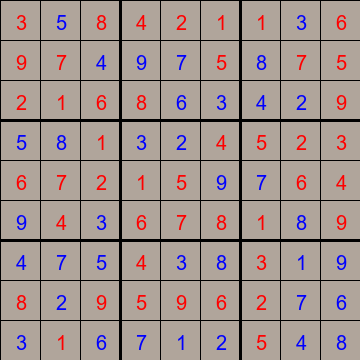

46


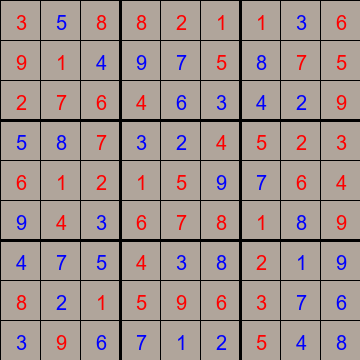

51


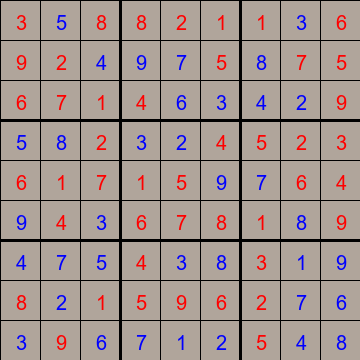

55


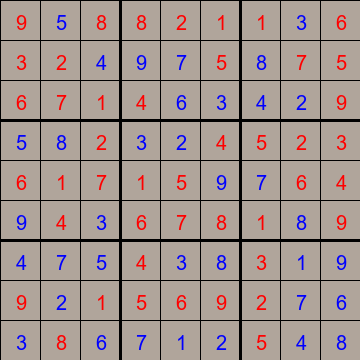

66


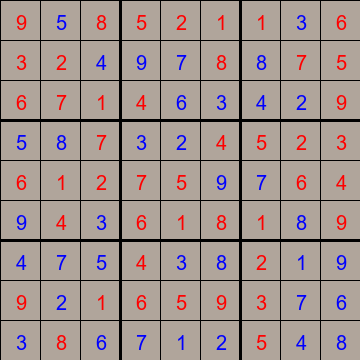

75


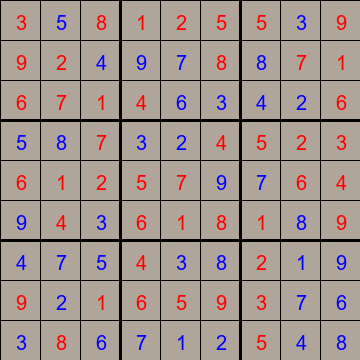

79


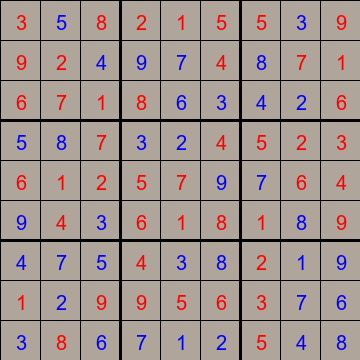

84


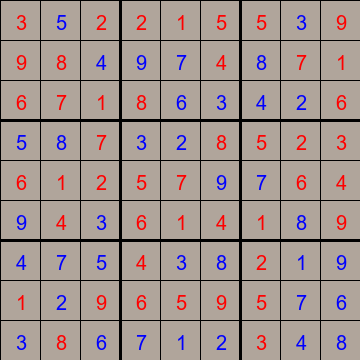

85


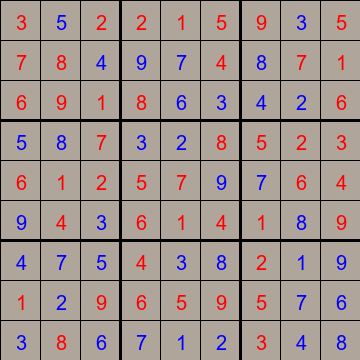

95


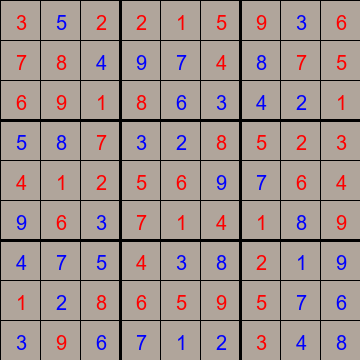

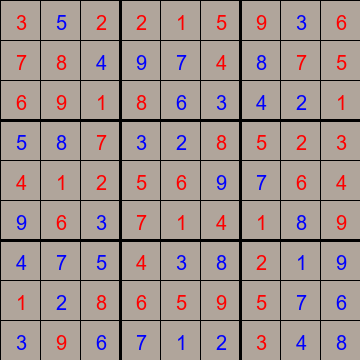

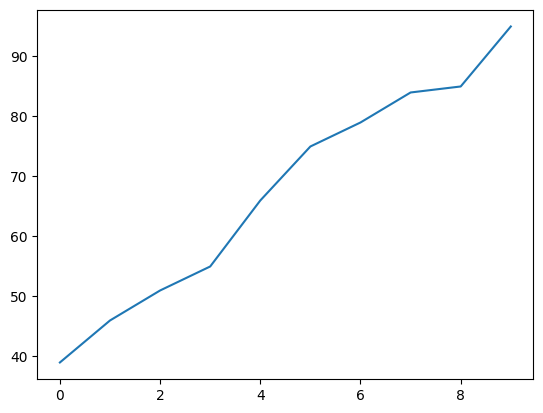

In [395]:
alpha = 0.99
T0 = 10
T = T0
steps = 10
energy_steps = []
for i in range(steps):
    for _ in range(5):
        first, second, s_no = generate_neighbor()
        delta = calculate_change(first, second, s_no)
        if delta < 0:
            energy += delta
            swap(first, second, s_no)
        else:
            p1 = np.exp(-delta / T)
            if p1 > np.random.uniform(0, 1):
                energy += delta
                swap(first, second, s_no)
    T = T *alpha
    print(energy)
    show_sudoku(sudoku)
    energy_steps.append(energy)
show_sudoku(sudoku)
plt.plot([i for i in range(steps)], energy_steps)
plt.show()